<a href="https://colab.research.google.com/github/bhattacharjee/msc-ai-project/blob/main/DeepANN/deep_ann_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
USE_FLOAT32 = False
REDUCE_DF_SIZE = True
NUM_EPOCHS = 20
BATCH_SIZE = 32
INCLUDE_NAPIERONE = True

!pip install tensorflow-addons

import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging, sys, random, glob
from google.colab import drive
from functools import lru_cache
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import IPython

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import gc
import tensorflow_addons as tfa

drive.mount("/content/drive")

def set_random_seed():
    np.random.seed(1)
    random.seed(1)
    tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

!if [[ -d /content/drive/MyDrive/MSCPROJDATA && ! -d MSCPROJDATA ]]; then cp -r /content/drive/MyDrive/MSCPROJDATA .; fi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
 def plot_history(history):
    import matplotlib.pyplot as plt
    keys = [str(k) for k in history.history.keys()]
    keys = keys[0:(len(keys)//2)]

    length = 10
    height = length * 0.5 * len(keys)
    plt.rcParams["figure.figsize"] = (length, height)
    plt.rcParams['font.size'] = 15
    
    fig, ax = plt.subplots(len(keys))


    for i in range(len(keys)):
        key = keys[i]
        val_key = f"val_{key}"
        ax[i].plot(history.history[key], label=key)
        ax[i].plot(history.history[val_key], label=val_key)
        ax[i].legend()

    
    plt.show()

In [3]:
dataset_names = ["baseline", "advanced-only", "fourier-only", "baseline-and-fourier", "advanced-and-fourier", "advanced", "fourier"]
def get_columns_from_df(thisdf):
    baseline_columns = [c for c in thisdf.columns if c.startswith('baseline') and "head" not in c and "tail" not in c]
    baseline_columns = [c for c in baseline_columns if "filesize" not in c]
    baseline_columns = [c for c in baseline_columns if "begin" not in c and "end" not in c]

    advanced_columns = [c for c in thisdf.columns if "advanced" in c]
    advanced_columns = [c for c in advanced_columns if "begin" not in c and "end" not in c]
    advanced_columns = [c for c in advanced_columns if "head" not in c and "tail" not in c]
    advanced_columns = [c for c in advanced_columns if "start" not in c]
    advanced_columns_only = list(set(advanced_columns))
    advanced_columns = list(set(advanced_columns + baseline_columns))

    fourier_columns = [c for c in thisdf.columns if "fourier" in c and "value" not in c]
    fourier_columns = [c for c in fourier_columns if "1byte" in c]
    fourier_columns = [c for c in fourier_columns if "begin" not in c and "end" not in c]
    fourier_columns = [c for c in fourier_columns if "head" not in c and "tail" not in c]
    fourier_columns = [c for c in fourier_columns if "start" not in c]
    fourier_columns_only = list(set(fourier_columns))
    fourier_columns = list(set(advanced_columns + fourier_columns))
    
    baseline_and_advanced = list(set(baseline_columns + advanced_columns_only))
    baseline_and_fourier = list(set(baseline_columns + fourier_columns_only))
    advanced_and_fourier = list(set(advanced_columns_only + fourier_columns_only))

    all_columns = [c for c in thisdf.columns]
    
    return {\
        "all_columns": all_columns,
        "Baseline": baseline_columns,\
        "Advanced Only": advanced_columns_only,\
        "Fourier Only": fourier_columns_only,\
        "Baseline and Advanced": advanced_columns,\
        "Baseline and Fourier": baseline_and_fourier,\
        "Advanced and Fourier": advanced_and_fourier,\
        "Baseline, Advanced and Fourier": fourier_columns,\
    }


def reduce_df_size(df):
    original_usage = df.memory_usage().sum() / (1024**2)
    for col in df.columns:
        if "fourier.value" in col or \
            "tail" in col or \
            "head" in col or \
            "end" in col or \
            "begin" in col:
            df.drop([col], axis=1, inplace=True)
            continue
        if USE_FLOAT32:
            if "float64" in str(df[col].dtype):
                df[col] = df[col].astype('float32')
        elif "int64" in str(df[col].dtype):
            df[col] = df[col].astype("int8")
    new_usage = df.memory_usage().sum() / (1024**2)
    return df

def call_gc():
    for i in range(3):
        for j in range(3):
            gc.collect(j)

@lru_cache(maxsize=5)
def load_datasets():
    global INCLUDE_NAPIERONE
    datasets = dict()
    print("Reloading Datasets")
    for file in glob.glob("MSCPROJDATA/**.parquet.gz", recursive=True):
        if INCLUDE_NAPIERONE or not file.startswith("MSCPROJDATA/n1"):
            df = pd.read_parquet(file)
            datasets[file] = df
            df["is_encrypted"] = 1 if "encr" in file.lower() else 0
    
            if REDUCE_DF_SIZE:
                df = reduce_df_size(df)

            df = df.sample(frac=1).reset_index(drop=True)
            datasets[file] = df
            call_gc()

    return datasets

@lru_cache(maxsize=5)
def get_columns():
    datasets = load_datasets()
    df = list(datasets.values())[0]
    return get_columns_from_df(df)


In [4]:
@lru_cache(maxsize=5)
def get_train_test_df():
    datasets = load_datasets()
    df = pd.concat([v for v in datasets.values()])
    x_cols = [str(c) for c in df.columns if "is_encrypted" != str(c)]
    y_cols = "is_encrypted"

    df = df.sample(frac=1).reset_index(drop=True)
    df.fillna(0.0)

    X = df[x_cols]
    y = df[y_cols]

    min_max_scaler = MinMaxScaler()
    X = X - X.min()
    X = X / X.max()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [5]:
class Model:
    @staticmethod
    def print_and_plot(model):
        print(model.summary())
        plot = tf.keras.utils.plot_model(
            model,
            show_shapes=True,
            expand_nested=True)
        IPython.display.display(plot)

    @staticmethod
    def create(name:str, columns:list):
        X_train, X_test, y_train, y_test = get_train_test_df()
        X_train = X_train[columns].to_numpy()

        model = tf.keras.Sequential(
            [
                layers.Dense(8, input_dim=X_train.shape[1], activation='relu', name="Dense-8"),
                layers.Dropout(0.2),
                layers.Dense(4, activation = 'relu', name="Dense-4"),
                layers.Dropout(0.2),
                layers.Dense(2, activation = 'relu', name="Dense-2"),
                layers.Dense(1, activation = 'sigmoid')
            ]
        )

        model.compile(\
            loss = 'binary_crossentropy',
            optimizer = 'adam',\
            metrics = [
                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tfa.metrics.F1Score(num_classes=1, name='f1_score'),
            ])
            #callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")])
        
        return model

    @staticmethod
    def train_model(name):
        tf.random.set_seed(42)
        np.random.seed(42)
        X_train, X_test, y_train, y_test = get_train_test_df()

        columns = get_columns()
        columns = columns[name]

        X_train = X_train[columns]
        X_test = X_test[columns]

        n_cross_val = X_train.shape[0]
        n_train = n_cross_val - n_cross_val // 5
        n_cross_val = n_cross_val // 5

        X_cross_val = X_train.tail(n_cross_val)
        y_cross_val = y_train[-n_cross_val:]

        X_train = X_train.head(n_train)
        y_train = y_train[:n_train]

        es_clbk = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

        model = Model.create(name, columns)
        history = model.fit(X_train, y_train,
                            epochs=NUM_EPOCHS,
                            validation_data=(X_cross_val, y_cross_val),
                            callbacks=[es_clbk],
                            batch_size=BATCH_SIZE)

        Model.print_and_plot(model)
        
        y_pred = model.predict(X_test)

        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true=y_test, y_score=y_pred)
        auc = sklearn.metrics.auc(fpr, tpr)
        y_pred = y_pred > 0.5

        acc = sklearn.metrics.accuracy_score(y_test, y_pred)
        prec = sklearn.metrics.precision_score(y_test, y_pred)
        rec = sklearn.metrics.recall_score(y_test, y_pred)
        f1 = sklearn.metrics.f1_score(y_test, y_pred)
        
        return name, model, history, acc, f1, prec, rec, auc

In [6]:
class Runner:
    def __init__(self):
        self.scores_dict = {
            "MeasureName": [],
            "Accuracy": [],
            "F1": [],
            "Precision": [],
            "Recall": [],
            "AUC": [],
        }
        self.training_histories = dict()
        self.scores_df = None

    def run(self, name:str):
        message = f"Running : {name}"
        print(message)
        print("-" * len(message))

        name, model, history, accuracy, f1, precision, recall, auc = Model.train_model(name)
        self.training_histories[name] = history
        self.scores_dict["MeasureName"].append(name)
        self.scores_dict["Accuracy"].append(accuracy)
        self.scores_dict["F1"].append(f1)
        self.scores_dict["Precision"].append(precision)
        self.scores_dict["Recall"].append(recall)
        self.scores_dict["AUC"].append(auc)

    def print(self):
        df = pd.DataFrame(self.scores_dict)
        print(df)
    
    def print_latex(self):
        df = pd.DataFrame(self.scores_dict)
        print(df.round(3).to_latex(index=False))

    def pickle_histories(self, pickle_filename):
        import pickle
        with open(pickle_filename, "wb") as f:
            pickle.dump(self.training_histories, f, pickle.HIGHEST_PROTOCOL)

    def save_result_df(self, csv_filename):
        df = pd.DataFrame(self.scores_dict)
        df.to_csv(csv_filename)

USING NAPIER ONE
******************************************

Reloading Datasets
Running : Baseline
------------------
Epoch 1/20
14713/14713 [==============================] - 68s 4ms/step - loss: 0.6563 - accuracy: 0.5891 - precision: 0.5668 - recall: 0.8421 - f1_score: 0.6778 - val_loss: 0.6164 - val_accuracy: 0.6419 - val_precision: 0.5926 - val_recall: 0.9535 - val_f1_score: 0.6755
Epoch 2/20
14713/14713 [==============================] - 66s 4ms/step - loss: 0.6259 - accuracy: 0.6336 - precision: 0.5948 - recall: 0.8949 - f1_score: 0.6778 - val_loss: 0.6067 - val_accuracy: 0.6451 - val_precision: 0.5967 - val_recall: 0.9391 - val_f1_score: 0.6755
Epoch 3/20
14713/14713 [==============================] - 66s 4ms/step - loss: 0.6225 - accuracy: 0.6379 - precision: 0.5960 - recall: 0.9120 - f1_score: 0.6778 - val_loss: 0.6043 - val_accuracy: 0.6445 - val_precision: 0.5968 - val_recall: 0.9341 - val_f1_score: 0.6755
Epoch 4/20
14713/14713 [==============================] - 66s 4ms/ste

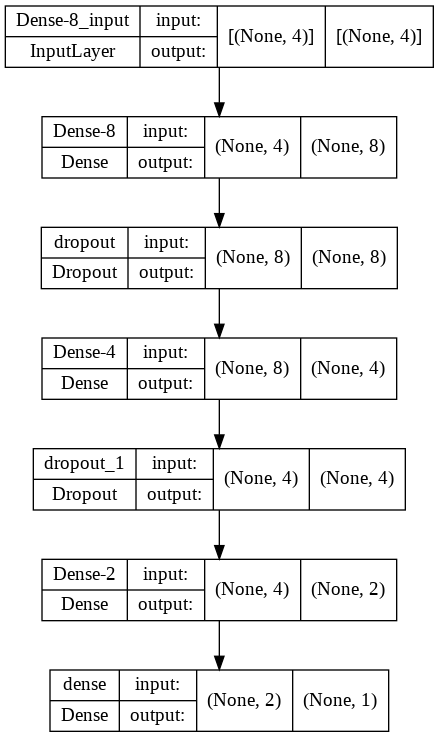

Running : Advanced Only
-----------------------
Epoch 1/20
14713/14713 [==============================] - 67s 4ms/step - loss: 0.6248 - accuracy: 0.6177 - precision: 0.6165 - recall: 0.6727 - f1_score: 0.6778 - val_loss: 0.5389 - val_accuracy: 0.7210 - val_precision: 0.8756 - val_recall: 0.5280 - val_f1_score: 0.6755
Epoch 2/20
14713/14713 [==============================] - 66s 4ms/step - loss: 0.5528 - accuracy: 0.6615 - precision: 0.7636 - recall: 0.4920 - f1_score: 0.6778 - val_loss: 0.4254 - val_accuracy: 0.7969 - val_precision: 0.7318 - val_recall: 0.9497 - val_f1_score: 0.6755
Epoch 3/20
14713/14713 [==============================] - 67s 5ms/step - loss: 0.4451 - accuracy: 0.7559 - precision: 0.6997 - recall: 0.9179 - f1_score: 0.6778 - val_loss: 0.3283 - val_accuracy: 0.8216 - val_precision: 0.7994 - val_recall: 0.8682 - val_f1_score: 0.6755
Epoch 4/20
14713/14713 [==============================] - 65s 4ms/step - loss: 0.4135 - accuracy: 0.7510 - precision: 0.6913 - recall: 0.92

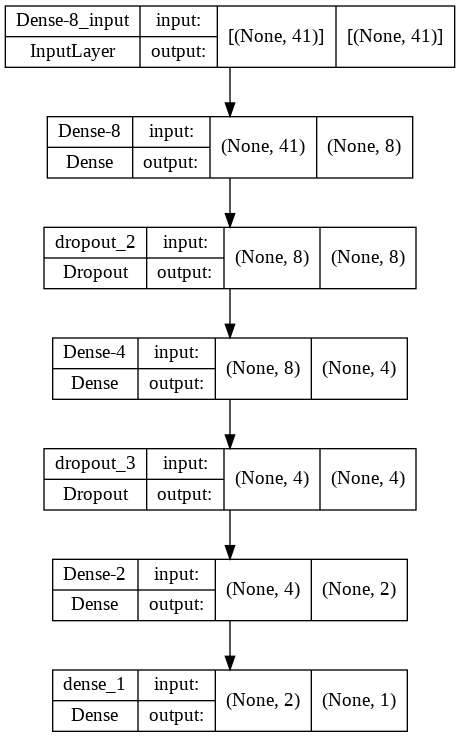

Running : Fourier Only
----------------------
Epoch 1/20
14713/14713 [==============================] - 67s 4ms/step - loss: 0.6095 - accuracy: 0.6643 - precision: 0.6205 - recall: 0.8887 - f1_score: 0.6778 - val_loss: 0.5833 - val_accuracy: 0.6804 - val_precision: 0.6294 - val_recall: 0.9080 - val_f1_score: 0.6755
Epoch 2/20
14713/14713 [==============================] - 65s 4ms/step - loss: 0.5876 - accuracy: 0.6738 - precision: 0.6256 - recall: 0.9057 - f1_score: 0.6778 - val_loss: 0.5790 - val_accuracy: 0.6789 - val_precision: 0.6238 - val_recall: 0.9334 - val_f1_score: 0.6755
Epoch 3/20
14713/14713 [==============================] - 65s 4ms/step - loss: 0.5860 - accuracy: 0.6739 - precision: 0.6256 - recall: 0.9068 - f1_score: 0.6778 - val_loss: 0.5774 - val_accuracy: 0.6796 - val_precision: 0.6251 - val_recall: 0.9290 - val_f1_score: 0.6755
Epoch 4/20
14713/14713 [==============================] - 66s 4ms/step - loss: 0.5847 - accuracy: 0.6746 - precision: 0.6260 - recall: 0.9076

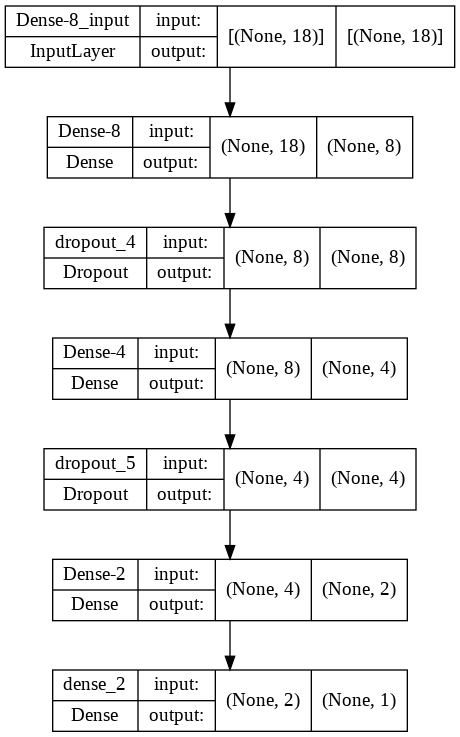

Running : Baseline and Advanced
-------------------------------
Epoch 1/20
14713/14713 [==============================] - 66s 4ms/step - loss: 0.6441 - accuracy: 0.6064 - precision: 0.5975 - recall: 0.7116 - f1_score: 0.6778 - val_loss: 0.5801 - val_accuracy: 0.6631 - val_precision: 0.9116 - val_recall: 0.3758 - val_f1_score: 0.6755
Epoch 2/20
14713/14713 [==============================] - 64s 4ms/step - loss: 0.5715 - accuracy: 0.6878 - precision: 0.7513 - recall: 0.5847 - f1_score: 0.6778 - val_loss: 0.5366 - val_accuracy: 0.6812 - val_precision: 0.8603 - val_recall: 0.4477 - val_f1_score: 0.6755
Epoch 3/20
14713/14713 [==============================] - 65s 4ms/step - loss: 0.5565 - accuracy: 0.6990 - precision: 0.7617 - recall: 0.6009 - f1_score: 0.6778 - val_loss: 0.4822 - val_accuracy: 0.7138 - val_precision: 0.9168 - val_recall: 0.4827 - val_f1_score: 0.6755
Epoch 4/20
14713/14713 [==============================] - 65s 4ms/step - loss: 0.5077 - accuracy: 0.7326 - precision: 0.802

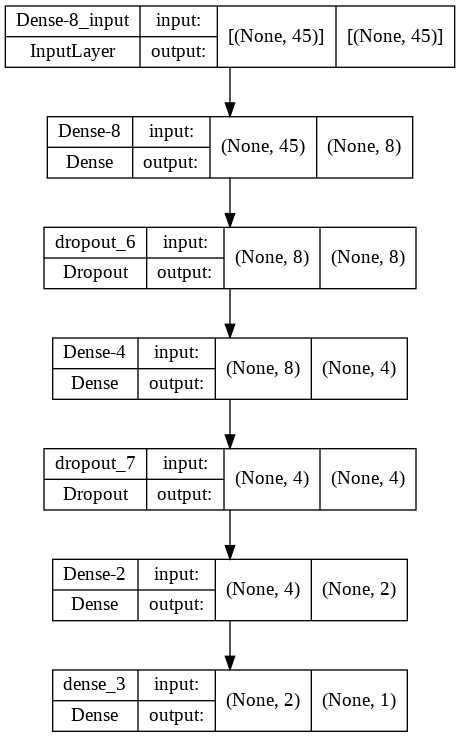

Running : Baseline and Fourier
------------------------------
Epoch 1/20
14713/14713 [==============================] - 66s 4ms/step - loss: 0.6150 - accuracy: 0.6631 - precision: 0.6234 - recall: 0.8658 - f1_score: 0.6778 - val_loss: 0.5711 - val_accuracy: 0.6961 - val_precision: 0.6398 - val_recall: 0.9247 - val_f1_score: 0.6755
Epoch 2/20
14713/14713 [==============================] - 65s 4ms/step - loss: 0.5886 - accuracy: 0.6850 - precision: 0.6359 - recall: 0.9021 - f1_score: 0.6778 - val_loss: 0.5610 - val_accuracy: 0.6989 - val_precision: 0.6429 - val_recall: 0.9215 - val_f1_score: 0.6755
Epoch 3/20
14713/14713 [==============================] - 65s 4ms/step - loss: 0.5830 - accuracy: 0.6869 - precision: 0.6380 - recall: 0.8999 - f1_score: 0.6778 - val_loss: 0.5513 - val_accuracy: 0.7013 - val_precision: 0.6413 - val_recall: 0.9403 - val_f1_score: 0.6755
Epoch 4/20
14713/14713 [==============================] - 64s 4ms/step - loss: 0.5777 - accuracy: 0.6858 - precision: 0.6383 

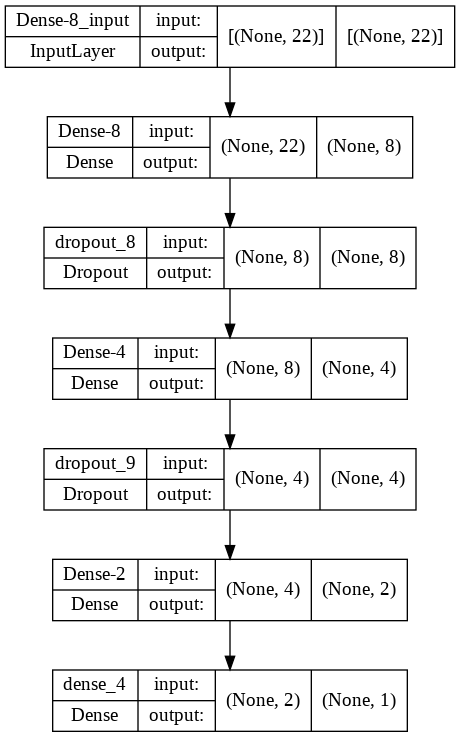

Running : Advanced and Fourier
------------------------------
Epoch 1/20
14713/14713 [==============================] - 65s 4ms/step - loss: 0.5858 - accuracy: 0.6535 - precision: 0.6499 - recall: 0.7028 - f1_score: 0.6781 - val_loss: 0.3587 - val_accuracy: 0.8115 - val_precision: 0.7540 - val_recall: 0.9355 - val_f1_score: 0.6779
Epoch 2/20
14713/14713 [==============================] - 64s 4ms/step - loss: 0.4083 - accuracy: 0.7582 - precision: 0.7271 - recall: 0.8460 - f1_score: 0.6840 - val_loss: 0.3101 - val_accuracy: 0.8171 - val_precision: 0.7396 - val_recall: 0.9899 - val_f1_score: 0.6861
Epoch 3/20
14713/14713 [==============================] - 65s 4ms/step - loss: 0.4182 - accuracy: 0.7867 - precision: 0.7141 - recall: 0.9737 - f1_score: 0.6885 - val_loss: 0.3590 - val_accuracy: 0.8216 - val_precision: 0.7546 - val_recall: 0.9635 - val_f1_score: 0.6878
Epoch 4/20
14713/14713 [==============================] - 65s 4ms/step - loss: 0.4178 - accuracy: 0.7875 - precision: 0.7149 

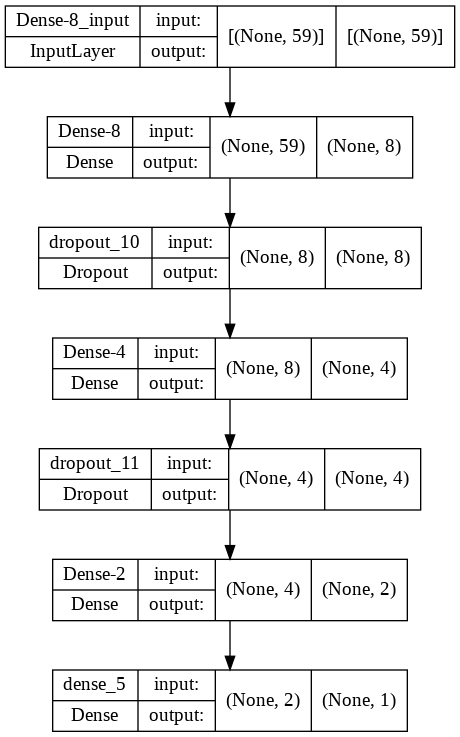

Running : Baseline, Advanced and Fourier
----------------------------------------
Epoch 1/20
14713/14713 [==============================] - 66s 4ms/step - loss: 0.5220 - accuracy: 0.7160 - precision: 0.6721 - recall: 0.8709 - f1_score: 0.6778 - val_loss: 0.3526 - val_accuracy: 0.8170 - val_precision: 0.7611 - val_recall: 0.9345 - val_f1_score: 0.6755
Epoch 2/20
14713/14713 [==============================] - 65s 4ms/step - loss: 0.4038 - accuracy: 0.7764 - precision: 0.7078 - recall: 0.9605 - f1_score: 0.6778 - val_loss: 0.3212 - val_accuracy: 0.8176 - val_precision: 0.7422 - val_recall: 0.9845 - val_f1_score: 0.6755
Epoch 3/20
14713/14713 [==============================] - 65s 4ms/step - loss: 0.3821 - accuracy: 0.7884 - precision: 0.7161 - recall: 0.9731 - f1_score: 0.6778 - val_loss: 0.3003 - val_accuracy: 0.8275 - val_precision: 0.7563 - val_recall: 0.9764 - val_f1_score: 0.6755
Epoch 4/20
14713/14713 [==============================] - 66s 4ms/step - loss: 0.3621 - accuracy: 0.7977 

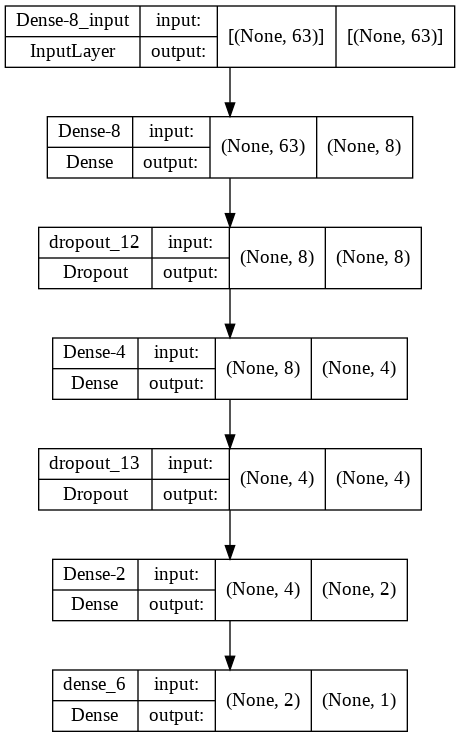

2022-04-18 22:24:21,698 - absl - WARNING - Function `_wrapped_model` contains input name(s) Dense-8_input with unsupported characters which will be renamed to dense_8_input in the SavedModel.
INFO:tensorflow:Assets written to: ram://597676ca-d445-4c49-bb35-4ab822b40b2f/assets
2022-04-18 22:24:22,413 - tensorflow - INFO - Assets written to: ram://597676ca-d445-4c49-bb35-4ab822b40b2f/assets
2022-04-18 22:24:22,725 - absl - WARNING - Function `_wrapped_model` contains input name(s) Dense-8_input with unsupported characters which will be renamed to dense_8_input in the SavedModel.
INFO:tensorflow:Assets written to: ram://29fb3d92-868f-4e57-9d48-70e2d54f6c80/assets
2022-04-18 22:24:23,116 - tensorflow - INFO - Assets written to: ram://29fb3d92-868f-4e57-9d48-70e2d54f6c80/assets
2022-04-18 22:24:23,450 - absl - WARNING - Function `_wrapped_model` contains input name(s) Dense-8_input with unsupported characters which will be renamed to dense_8_input in the SavedModel.
INFO:tensorflow:Assets w

In [7]:
# Run this if using NapierOne
print("USING NAPIER ONE")
print("******************************************")
print()
load_datasets.cache_clear()
get_columns.cache_clear()
get_train_test_df.cache_clear()

INCLUDE_NAPIERONE = True
runner = Runner()
# Now run all the different combinations of features
_ = [runner.run(str(c)) for c in get_columns().keys() if "all_" not in str(c).lower()]
runner.pickle_histories("n1.history.pickle")
runner.save_result_df("n1.DenseAnnResult.csv")
!mkdir -p /content/drive/MyDrive/ProjSave
!rm -f /content/drive/MyDrive/ProjSave/n1.history.pickle
!rm -f /content/drive/MyDrive/ProjSave/n1.DenseAnnResult.csv
!cp n1.history.pickle /content/drive/MyDrive/ProjSave
!cp n1.DenseAnnResult.csv /content/drive/MyDrive/ProjSave
!ls -l /content/drive/MyDrive/ProjSave

using_napier_runner = runner

In [ ]:
# Run this if not using Napier One
print("NOT USING NAPIER ONE")
print("******************************************")
print()
load_datasets.cache_clear()
get_columns.cache_clear()
get_train_test_df.cache_clear()

INCLUDE_NAPIERONE = False
runner = Runner()
# Now run all the different combinations of features
_ = [runner.run(str(c)) for c in get_columns().keys() if "all" != str(c).lower()]

runner.pickle_histories("history.pickle")
runner.save_result_df("DenseAnnResult.csv")
!mkdir -p /content/drive/MyDrive/ProjSave
!rm -f /content/drive/MyDrive/ProjSave/history.pickle
!rm -f /content/drive/MyDrive/ProjSave/DenseAnnResult.csv
!cp history.pickle /content/drive/MyDrive/ProjSave
!cp DenseAnnResult.csv /content/drive/MyDrive/ProjSave
!ls -l /content/drive/MyDrive/ProjSave

not_using_napier_runner = runner

NOT USING NAPIER ONE
******************************************

Reloading Datasets


In [ ]:
runner = using_napier_runner
print("USING NAPIER ONE")
print("******************************************")
runner.print()
print()
print("--------------------------------")
print()
runner.print_latex()
print()
print("--------------------------------")
print()
pd.DataFrame(runner.scores_dict)

In [ ]:
runner = not_using_napier_runner
print("NOT USING NAPIER ONE")
print("******************************************")
runner.print()
print()
print("--------------------------------")
print()
runner.print_latex()
print()
print("--------------------------------")
print()
pd.DataFrame(runner.scores_dict)